<CENTER><img src="http://localhost:8888/notebooks/notebooks/images/opendata-top-transblack.png" style="width:30%"></CENTER>

<CENTER><h1>Searching for the Higgs boson in the Hyy channel C++ notebook example</h1></CENTER>

In [1]:
//%jsroot on

In [2]:
// Creates a TChain to be used by the Analysis.C class
#include <TROOT.h>
#include <TChain.h>
#include <TFile.h>
#include <iostream>
#include <string>
#include <stdio.h>

In [3]:
TString path = "http://opendata.atlas.cern/release/samples/2019/GamGam/"

(TString &) @0x7fd7b18ca028


In [4]:
TChain* chain_data = new TChain("mini");
chain_data->AddFile(path+"Data/dataA_yy.root/"); 
//chain_data->AddFile(path+"Data/dataB_yy.root/");
//chain_data->AddFile(path+"Data/dataC_yy.root/");
//chain_data->AddFile(path+"Data/data302737-303338_yy.root/");

In [5]:
Int_t  photon_n = -1;      //number of preselected photons

Float_t photon_pt[5],      //transverse momentum of the photon
        photon_eta[5],     //pseudorapidity of the photon
        photon_phi[5],     //azimuthal angle of the photon
        photon_E[5];       //energy of the photon

In [6]:
chain_data->SetBranchAddress("photon_pt",        &photon_pt);
chain_data->SetBranchAddress("photon_n",         &photon_n);
chain_data->SetBranchAddress("photon_eta",       &photon_eta);
chain_data->SetBranchAddress("photon_phi",       &photon_phi);
chain_data->SetBranchAddress("photon_E",         &photon_E);

In [7]:
//Invariant mass histograms definition
TH1F *h_M_Hyy   = new TH1F("h_M_Hyy"  ,  "Invariant Mass of the H (Hyy) ; M_Hyy[GeV] ; # de eventos" ,20,0,150);

In [8]:
h_M_Hyy->SetMarkerSize(2.0);
h_M_Hyy->SetLineColor(kBlue);
h_M_Hyy->SetFillColor(kBlue-10);

In [9]:
std::cout << "Analysed a total of: " << photon_n << " events out of " << chain_data->GetEntries() << " in this sample" << std::endl;

Analysed a total of: -1 events out of 430348 in this sample


In [10]:
int nentries, nbytes, i;
nentries = (Int_t)chain_data->GetEntries();

std::cout << " Total number of entries to analyze: " << nentries << std::endl;
// Preselection of good photons
for (i=0; i < nentries; i++)
{
    nbytes =  chain_data->GetEntry(i);
    
    int goodphoton_index[2];
    int goodphoton_n = 0;
    int photon_index =0;
    int goodphoton1_index = goodphoton_index[0];
    int goodphoton2_index = goodphoton_index[1];
    for(unsigned int i=0; i<photon_n; i++){
      // photons are tight
        if( photon_isTightID->at(i) ){ 
           // photons with 25 GeV and excluding the transition region between the barrel and endcap calorimeters
          if( photon_pt->at(i) >25000. && TMath::Abs(photon_eta->at(i)<2.37) && ( TMath::Abs(photon_eta->at(i) < 1.37) || TMath::Abs(photon_eta->at(i) > 1.52) ) ){
              goodphoton_n = goodphoton_n + 1;
              goodphoton_index[photon_index] = i;
              photon_index++;
        }
      }
    }    
   
    
    // TLorentzVector definitions 
    TLorentzVector Photon_1  = TLorentzVector();
    TLorentzVector Photon_2  = TLorentzVector();
    
    Photon_1.SetPtEtaPhiE(photon_pt->at(goodphoton1_index), photon_eta->at(goodphoton1_index), photon_phi->at(goodphoton1_index),photon_E->at(goodphoton1_index));
    Photon_2.SetPtEtaPhiE(photon_pt->at(goodphoton2_index), photon_eta->at(goodphoton2_index), photon_phi->at(goodphoton2_index),photon_E->at(goodphoton2_index));

    
    //Exactly two photons   
    if(goodphoton_n==2 ){
        float dPhi_yy = fabs(photon_phi->at(goodphoton1_index) - photon_phi->at(goodphoton2_index) );
        dPhi_yy       = dPhi_yy < TMath::Pi() ? dPhi_yy : 2*TMath::Pi() - dPhi_yy;
        float m_yy = sqrt( 2 * Photon_1.Pt() * Photon_2.Pt() * (cosh( Photon_1.Eta() - Photon_2.Eta()) - cos(dPhi_yy)));
        
        //Calculation of the Invariant Mass using TLorentz vectors
        TLorentzVector Photon_12 = Photon_1 + Photon_2;                   
        float mass_inv_GeV = Photon_12.M()/1000.;
        h_M_Hyy->Fill(mass_inv_GeV);
    } 
}


input_line_80:20:24: error: member reference base type 'Float_t' (aka 'float')
      is not a structure or union
          if( photon_pt->at(i) >25000. && TMath::Abs(photon_eta->at(i)<2...
              ~~~~~~~~~^ ~~
input_line_80:20:64: error: member reference base type 'Float_t' (aka 'float')
      is not a structure or union
          if( photon_pt->at(i) >25000. && TMath::Abs(photon_eta->at(i)<2...
                                                     ~~~~~~~~~~^ ~~
input_line_80:20:104: error: member reference base type 'Float_t' (aka 'float')
      is not a structure or union
  ...TMath::Abs(photon_eta->at(i)<2.37) && ( TMath::Abs(photon_eta->at(i) < 1...
                                                        ~~~~~~~~~~^ ~~
input_line_80:20:144: error: member reference base type 'Float_t' (aka 'float')
      is not a structure or union
  ...TMath::Abs(photon_eta->at(i) < 1.37) || TMath::Abs(photon_eta->at(i) > 1...
                                                        ~~~~~~~~~

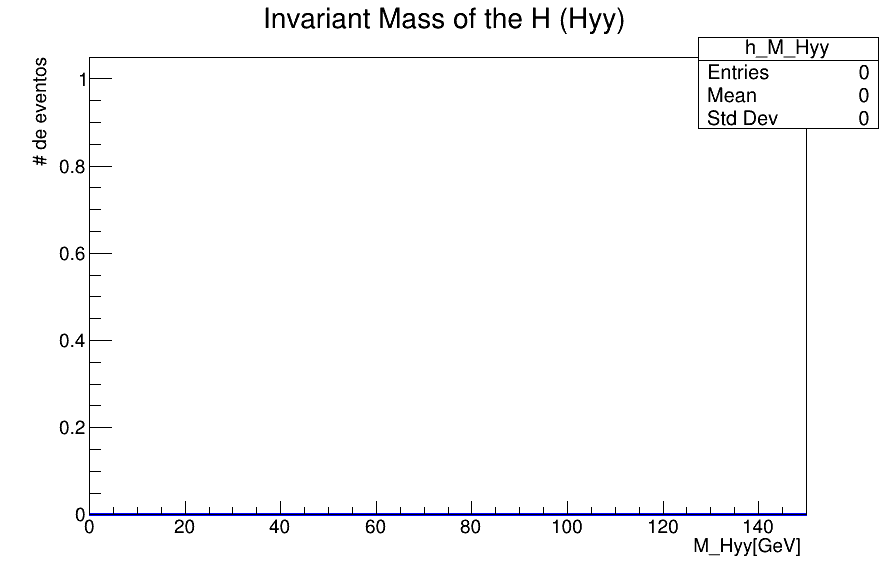

In [11]:
TCanvas *cz = new TCanvas("cz","cz",10,10,900,600);
TText tz; tz.SetTextFont(42); tz.SetTextAlign(21);
h_M_Hyy->Draw();
cz->Draw();